In [1]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Process, Queue

In [2]:
class RandomAction:
    def __init__(self, n_states=19, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = np.random.choice([-1, 1])
        self.state += action
        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [3]:
class OfflineLamdaGain:
    def __init__(self, alpha, lamda, epi=10, do=False):
        self.V = np.zeros(19)
        self.alpha = alpha
        self.lamda = lamda
        self.gamma = 1
        self.epi = epi

        if do:
            self.do()

    def do(self):
        env = RandomAction()
        
        for episode in range(self.epi):
            states = []
            rewards = []
            state = env.reset()
            done = False

            states.append(state)
            
            while not done:
                state, reward, done = env.step()

                states.append(state)
                rewards.append(reward)
            
            G_s = []
            for t in range(len(rewards)):
                G = 0
                g = 0
                for n in range(t, len(rewards)):
                    g += self.gamma ** (n - t) * rewards[n]
                    
                    if states[n+1] >= 19 or states[n+1] < 0:
                        ns_V = 0
                    else:
                        ns_V = self.V[states[n+1]]
                        
                    my_g = g + self.gamma ** (n - t + 1) * ns_V
                    G += self.lamda ** (n - t) * my_g
                G *= 1 - self.lamda
                G += self.lamda ** (len(rewards) - t) * g
                G_s.append(G)

            new_V = self.V.copy()
            for t in range(len(rewards)):
                if states[t] not in states[:t]:  # first visit
                    new_V[states[t]] += self.alpha * (G_s[t] - self.V[states[t]])
            self.V = new_V
            if episode == 0:
                self.G_s = G_s

In [4]:
g1 = OfflineLamdaGain(0.2, 0.8, epi=1000, do=True)

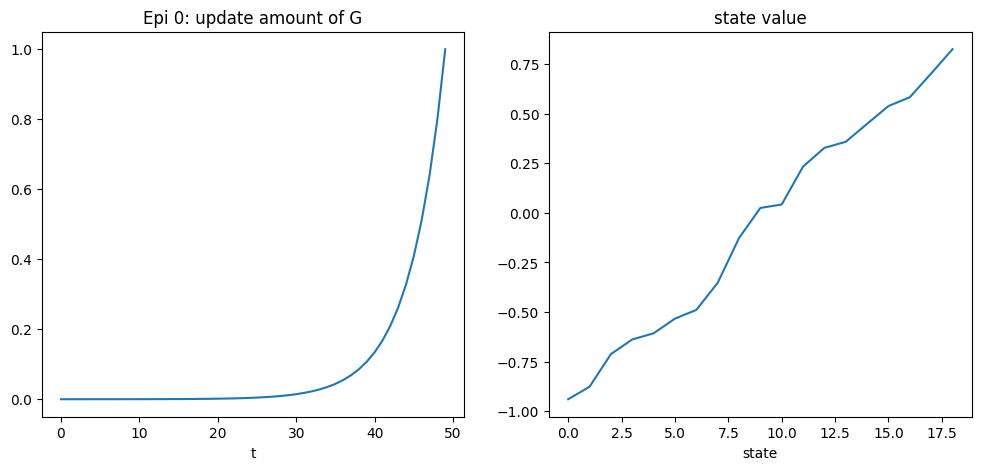

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(g1.G_s)
ax[0].set_xlabel('t')
ax[0].set_title('Epi 0: update amount of G')

ax[1].plot(g1.V)
ax[1].set_xlabel('state')
ax[1].set_title('state value')

plt.show()

In [6]:
def RMS_RA(V):
    V = np.array(V)
    return np.sqrt(np.mean((V - np.linspace(-1, 1, 21)[1:-1])**2))

In [7]:
q = Queue()

alphas = np.linspace(0, 1, 51)
lamda_s = [0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]

def work(alpha, rd_seed):
    np.random.seed(rd_seed)

    table_ = []
    for lamda in lamda_s:
        gs = [OfflineLamdaGain(alpha, lamda, do=True) for _ in range(200)]
        TD_RMS = [RMS_RA(g.V) for g in gs]
        table_.append(np.mean(TD_RMS, axis=0))

    q.put((alpha, table_))

In [8]:
th_s = []

for alpha in alphas:
    th_s.append(Process(target=work, args=(alpha, np.random.randint(0, 1000000))))

for th in th_s:
    th.start()

for th in th_s:
    th.join()

In [9]:
table = []
for i in range(len(alphas)):
    table.append(q.get())
    table.sort(key=lambda x: x[0])
    n_table = np.array([x[1] for x in table])

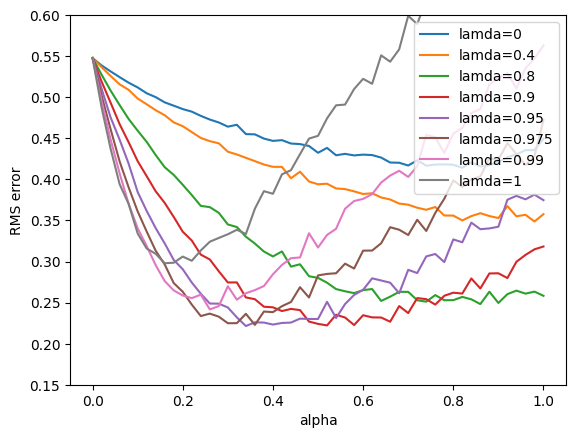

In [10]:
for i in range(len(lamda_s)):
    plt.plot(alphas, n_table[:, i], label=f'lamda={lamda_s[i]}')

plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.legend()
plt.ylim([0.15, 0.6])
plt.show()